# Non-English Retrieval

PyTerrier uses default settings that are conducive to text written in English. In this notebook, we show how to use it for non-English text.

First, install pyterrier from pip:

In [1]:
!pip install -q --upgrade python-terrier

Import and initialize pyterrier and other needed packages.

In [2]:
import os
import multiprocessing
import nltk
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import pyterrier as pt
if not pt.started():
    pt.init()
from pyterrier.measures import *

PyTerrier 0.6.0 has loaded Terrier 5.5 (built by craigmacdonald on 2021-05-20 13:12)


For these examples, we will use the [WikIR multi-lingual retrieval benchmarks](https://ir-datasets.com/wikir.html). They test a search engine's ability to retrieve the lead paragrahs from Wikipedia articles based on the article's title (or links to the corresponding article in the first sentence.) More details about these datasets can be found in this article:
> Jibril Frej, Didier Schwab, and Jean-Pierre Chevallet. [MLWIKIR: A Python toolkit for building large-scaleWikipedia-based Information Retrieval Datasets in Chinese,English, French, Italian, Japanese, Spanish and more](https://www.irit.fr/CIRCLE/wp-content/uploads/2020/06/CIRCLE20_22.pdf). CIRCLE 2020.

In [3]:
# Spanish test set
dataset = pt.get_dataset('irds:wikir/es13k/test')

The dataset contains 645,901 documents.

We will now construct 3 versions of the index using different pre-processing techniques:
 1. No stemming (indexing time: ~2minutes)
 2. Stemming with Terrier's [Spanish Snowball Stemmer](http://terrier.org/docs/v5.2/javadoc/org/terrier/terms/SpanishSnowballStemmer.html) (indexing time: 2mins 47secs)
 3. Pre-processing as described in the original paper using nltk (indexing time: 2minutes 36 seconds w/ multiprocessing over 16 cores)

In [4]:
# No Stemming
if not os.path.exists('./wikir-es13k-nostem'):
    indexer = pt.IterDictIndexer('./wikir-es13k-nostem')
    indexer.setProperty("tokeniser", "UTFTokeniser") # Replaces the default EnglishTokeniser, which makes assumptions specific to English
    indexer.setProperty("termpipelines", "") # Removes the default PorterStemmer (English)
    index_nostem = indexer.index(dataset.get_corpus_iter())
else:
    index_nostem = pt.IndexRef.of('./wikir-es13k-nostem/data.properties')

wikir/es13k/test documents: 645901it [02:06, 5103.42it/s]


In [5]:
# Spanish Snowball Stemmer
if not os.path.exists('./wikir-es13k-stem'):
    indexer = pt.IterDictIndexer('./wikir-es13k-stem')
    indexer.setProperty("tokeniser", "UTFTokeniser")  # Replaces the default EnglishTokeniser, which makes assumptions specific to English
    indexer.setProperty("termpipelines", "SpanishSnowballStemmer") # Applies Terrier's SpanishSnowballStemmer (replacing PorterStemmer)
    index_stem = indexer.index(dataset.get_corpus_iter())
else:
    index_stem = pt.IndexRef.of('./wikir-es13k-stem/data.properties')

wikir/es13k/test documents: 645901it [02:47, 3865.21it/s]


We now define a custom pre-processor for spanish text, based on the methodology reported in the MLWikIR paper. Specifically, we use `nltk` to perform stemming and stop word removal.

While this largely has the same effect as using Terrier's functionality for Spanish, you may need to use such an approach to handle languages that do not have built-in support in Terrier.

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
es_stemer = SnowballStemmer('spanish')
es_stopwords = set(stopwords.words('spanish'))
def es_preprocess(text):
    toks = word_tokenize(text) # tokenize
    toks = [t for t in toks if t.lower() not in es_stopwords] # remove stop words
    toks = [es_stemer.stem(t) for t in toks] # stem
    return ' '.join(toks) # combine toks back into a string

[nltk_data] Downloading package stopwords to /home/sean/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sean/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Custom Preprocessing
# NB: This custom pre-processing ends up being considerably slower than using Terrier's built-in processor,
# so we use the multiprocessing package to parallelize (400 docs/s vs 2000 docs/s).
def map_es_doc(document):
    # this function replaces the document text with the version that uses our custom pre-processing
    return {
        'docno': document['docno'],
        'text': es_preprocess(document['text'])
    }
if not os.path.exists('./wikir-es13k-custom_stem'):
    indexer = pt.IterDictIndexer('./wikir-es13k-custom_stem')
    indexer.setProperty("tokeniser", "UTFTokeniser")  # Replaces the default EnglishTokeniser, which makes assumptions specific to English
    indexer.setProperty("termpipelines", "") # Disable the default PorterStemmer (English)
    with multiprocessing.Pool() as pool:
        index_custom = indexer.index(pool.imap(map_es_doc, dataset.get_corpus_iter()))
else:
    index_custom = pt.IndexRef.of('./wikir-es13k-custom_stem/data.properties')

wikir/es13k/test documents: 199659it [00:48, 4173.20it/s]

18:12:52.752 [ForkJoinPool-3-worker-3] WARN  o.t.structures.indexing.Indexer - Adding an empty document to the index (199767) - further warnings are suppressed


wikir/es13k/test documents: 645901it [02:36, 4135.70it/s]

18:14:40.608 [ForkJoinPool-3-worker-3] WARN  o.t.structures.indexing.Indexer - Indexed 1 empty documents


We now build retrieval pipelines for each version of the index. Note that the retrieval properties and pre-processing should match those used to construct the index.

In [8]:
bm25_nostem = pt.BatchRetrieve(index_nostem, wmodel='BM25', properties={
    'tokeniser': 'UTFTokeniser',
    'termpipelines': '',
})
bm25_nostem.search('El Centro') # example search and working around #188

bm25_stem = pt.BatchRetrieve(index_stem, wmodel='BM25', properties={
    'tokeniser': 'UTFTokeniser',
    'termpipelines': 'SpanishSnowballStemmer',
})
bm25_stem.search('El Centro') # example search and working around #188

# to apply the es_preprocess function to the query text, use a pt.apply.query transformer
bm25_custom = pt.apply.query(lambda row: es_preprocess(row.query)) >> pt.BatchRetrieve(index_custom, wmodel='BM25', properties={
    'tokeniser': 'UTFTokeniser',
    'termpipelines': '',
})
bm25_custom.search('El Centro') # example search and working around #188

qid   docid   docno  rank     score    query_0  query
0     1   23194   23206     0  6.534872  El Centro  centr
1     1  207408  207768     1  6.511203  El Centro  centr
2     1  423971  425509     2  6.454733  El Centro  centr
3     1  478575  480332     3  6.406155  El Centro  centr
4     1  260522  261059     4  6.384291  El Centro  centr
..   ..     ...     ...   ...       ...        ...    ...
995   1  624530  626852   995  5.382656  El Centro  centr
996   1   36510   36538   996  5.382656  El Centro  centr
997   1  574979  577139   997  5.382656  El Centro  centr
998   1  183209  183511   998  5.382656  El Centro  centr
999   1  260706  261245   999  5.382656  El Centro  centr

[1000 rows x 7 columns]

We can now test the retrieval effectiveness. We follow the MLWikIR paper and check the results in 2 settings: "title" and "first_sentence".

NB: Three queries in the collection contain only stop words that are removed by the custom processor. These give warnings in the output.

In [9]:
title_qrels = dataset.get_qrels().copy()
title_qrels.loc[title_qrels.label < 2, 'label'] = 0
pt.Experiment(
    [bm25_nostem, bm25_stem, bm25_custom],
    dataset.get_topics(),
    title_qrels,
    [nDCG@5, nDCG@10, nDCG@20, NumQ],
    names=['nostem', 'stem', 'custom'],
    round=4
)

/home/sean/miniconda3/envs/py39/lib/python3.9/site-packages/pyterrier/batchretrieve.py:189: UserWarning: Skipping empty query for qid 4263
  warn("Skipping empty query for qid %s" % qid)
/home/sean/miniconda3/envs/py39/lib/python3.9/site-packages/pyterrier/batchretrieve.py:189: UserWarning: Skipping empty query for qid 20261
  warn("Skipping empty query for qid %s" % qid)
/home/sean/miniconda3/envs/py39/lib/python3.9/site-packages/pyterrier/batchretrieve.py:189: UserWarning: Skipping empty query for qid 440
  warn("Skipping empty query for qid %s" % qid)


name  nDCG@5  nDCG@10  nDCG@20    NumQ
0  nostem  0.2790   0.3202   0.3456  1298.0
1    stem  0.2656   0.3049   0.3307  1299.0
2  custom  0.3014   0.3377   0.3621  1296.0

In [10]:
pt.Experiment(
    [bm25_nostem, bm25_stem, bm25_custom],
    dataset.get_topics(),
    dataset.get_qrels(),
    [nDCG@5, nDCG@10, nDCG@20, NumQ],
    names=['nostem', 'stem', 'custom'],
    round=4
)

/home/sean/miniconda3/envs/py39/lib/python3.9/site-packages/pyterrier/batchretrieve.py:189: UserWarning: Skipping empty query for qid 4263
  warn("Skipping empty query for qid %s" % qid)
/home/sean/miniconda3/envs/py39/lib/python3.9/site-packages/pyterrier/batchretrieve.py:189: UserWarning: Skipping empty query for qid 20261
  warn("Skipping empty query for qid %s" % qid)
/home/sean/miniconda3/envs/py39/lib/python3.9/site-packages/pyterrier/batchretrieve.py:189: UserWarning: Skipping empty query for qid 440
  warn("Skipping empty query for qid %s" % qid)


name  nDCG@5  nDCG@10  nDCG@20    NumQ
0  nostem  0.2738   0.2677   0.2825  1298.0
1    stem  0.2580   0.2526   0.2670  1299.0
2  custom  0.2855   0.2759   0.2871  1296.0

These results are similar to those reported for BM25 by the original authors. In fact, using the custom processing technique reports higher performance than what was originally reported (e.g., title nDCG@5 0.2793 -> 0.3014).

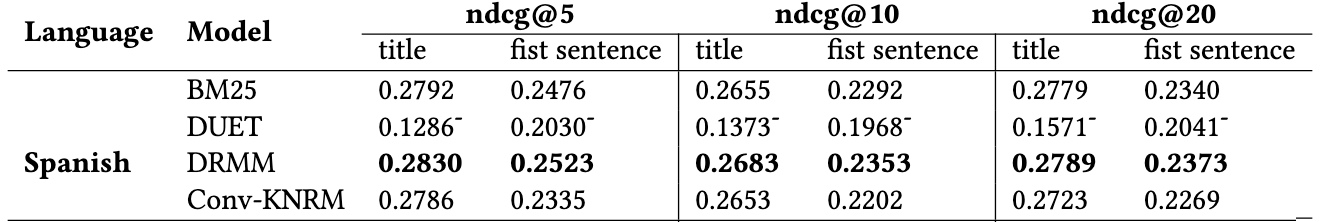